In [1]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from jax import random
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from numpyro.contrib.funsor import config_enumerate, infer_discrete
from numpyro.infer import SVI, TraceEnum_ELBO, Trace_ELBO, init_to_value
import numpyro.optim as optim

#import AutoDiagonalNormal from numpyro.infer.autoguide
from numpyro.infer.autoguide import AutoDiagonalNormal

/Users/naef/miniforge3/envs/numpyro/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Define the Mixture Model
def mixture_model(x, y=None):
    # Prior for the category probabilities
    category_probs = numpyro.sample("category_probs", dist.Dirichlet(jnp.array([1.0, 1.0])))

    # Priors for the intercepts and slope
    intercept_1 = numpyro.sample("intercept_1", dist.Normal(0, 10))
    intercept_2 = numpyro.sample("intercept_2", dist.Normal(0, 10))
    slope_2 = numpyro.sample("slope_2", dist.Normal(0, 10))

    # Prior for the observation noise
    sigma = numpyro.sample("sigma", dist.Exponential(1.0))

    # Determine the category for each data point
    with numpyro.plate("data", len(x)):
        category = numpyro.sample("category", dist.Categorical(category_probs))

        # Model based on category
        mean = jnp.where(category == 0,
                         intercept_1,
                         intercept_2 + slope_2 * x)

        # Gaussian likelihood
        numpyro.sample("y", dist.Normal(mean, sigma), obs=y)


In [2]:
@config_enumerate
def mixture_model_0(x, y=None):
    # Prior for the category probabilities
    category_probs = numpyro.sample("category_probs", dist.Dirichlet(jnp.array([1.0, 1.0])))

    # Priors for the intercepts and slope
    intercept_1 = numpyro.sample("intercept_1", dist.Normal(0, 10))
    intercept_2 = numpyro.sample("intercept_2", dist.Normal(0, 10))
    slope_2 = numpyro.sample("slope_2", dist.Normal(0, 10))

    # Prior for the observation noise
    sigma = numpyro.sample("sigma", dist.Exponential(1.0))

    # Enumerate the category for each data point
    with numpyro.plate("data", len(x)):
        category = numpyro.sample("category", dist.Categorical(category_probs), infer={'enumerate': 'parallel'})

        # Model based on category
        mean = jnp.where(category == 0,
                         intercept_1,
                         intercept_2 + slope_2 * x)

        # Gaussian likelihood
        numpyro.sample("y", dist.Normal(mean, sigma), obs=y)

In [10]:
@config_enumerate
def mixture_model(x, y=None):
    # Prior for the category probabilities
    category_probs = numpyro.sample("category_probs", dist.Dirichlet(jnp.array([1.0, 1.0])))

    # Priors for the intercepts and slope
    with numpyro.plate("components", 2):
        intercept = numpyro.sample("intercept", dist.Normal(0.0, 10))
        slope = numpyro.sample("slope", dist.Normal(0.0, 10))   
   
    # Prior for the observation noise
    sigma = numpyro.sample("sigma", dist.Exponential(1.0))

    # Enumerate the category for each data point
    print(len(x))
    with numpyro.plate("data", len(x)):
        category = numpyro.sample("category", dist.Categorical(category_probs))
        print(category.shape)

        # Model based on category
        mean = intercept[category] + slope[category] * x


        # Gaussian likelihood
        numpyro.sample("y", dist.Normal(mean, sigma), obs=y)


In [11]:
def generate_data(n=100, seed=0):
    key = random.PRNGKey(seed)
    x = jnp.linspace(-1, 1, n)
    true_intercept_1 = 3
    true_intercept_2 = -1
    true_slope_2 = 2
    true_category_probs = jnp.array([0.3, 0.7])  # 30% category 1, 70% category 2
    
    # Split the key for generating categories and noise
    key, subkey = random.split(key)
    categories = random.choice(subkey, 2, shape=(n,), p=true_category_probs)

    # Generate y values based on categories
    y = jnp.where(categories == 0,
                 true_intercept_1 + random.normal(key, shape=(n,)) * 0.5,
                 true_intercept_2 + true_slope_2 * x + random.normal(key, shape=(n,)) * 0.5)
    return x, y, categories



requires pip install funsor

Text(0.5, 1.0, 'category [1 1 1 0 1 0 1 1 1 1 1 0 0 1 1 0 0 1 1 1 1 1 0 1 0 1 0 1 1 0 1 1 1 1 0 1 1\n 0 1 0 1 1 0 1 1 1 0 1 1 0 1 1 1 0 1 1 0 0 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 0\n 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 1 1 1 0 1]')

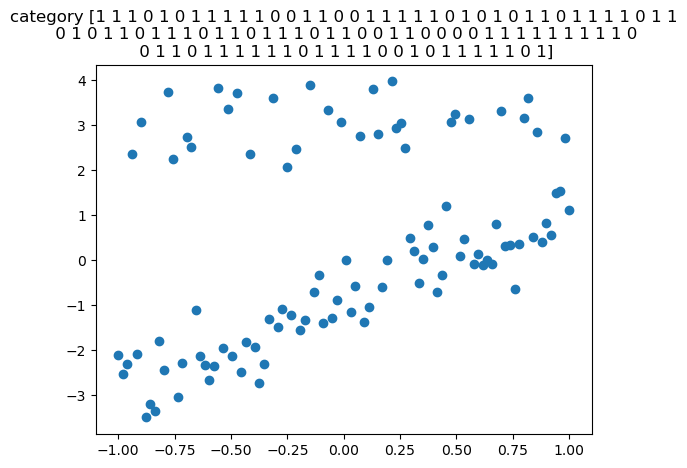

In [12]:
x, y, c = generate_data(seed=np.random.randint(0, 1000))
plt.scatter(x, y)
plt.title("category " + str(c))


In [13]:
# Set up the MCMC sampler
kernel = NUTS(mixture_model_0)
mcmc = MCMC(kernel, num_warmup=500, num_samples=1000)

# Run the sampler
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, x, y)

# Analyze the results
mcmc.print_summary()
samples = mcmc.get_samples()


sample: 100%|██████████| 1500/1500 [00:01<00:00, 964.12it/s, 3 steps of size 8.32e-01. acc. prob=0.88] 



                       mean       std    median      5.0%     95.0%     n_eff     r_hat
category_probs[0]      0.31      0.04      0.31      0.25      0.38   1041.19      1.00
category_probs[1]      0.69      0.04      0.69      0.62      0.75   1041.19      1.00
      intercept_1      3.07      0.10      3.07      2.89      3.21   1299.92      1.00
      intercept_2     -0.93      0.07     -0.93     -1.03     -0.81    953.72      1.00
            sigma      0.54      0.04      0.53      0.47      0.60    891.71      1.00
          slope_2      1.96      0.11      1.97      1.77      2.12   1344.27      1.00

Number of divergences: 0


def mixture_model_SVI(x, y=None):
    # Prior for the category probabilities
    category_probs = numpyro.sample("category_probs", dist.Dirichlet(jnp.array([1.0, 1.0])))

    # Priors for the intercepts and slope
    intercept_1 = numpyro.sample("intercept_1", dist.Normal(0, 10))
    intercept_2 = numpyro.sample("intercept_2", dist.Normal(0, 10))
    slope_2 = numpyro.sample("slope_2", dist.Normal(0, 10))

    # Prior for the observation noise
    sigma = numpyro.sample("sigma", dist.Exponential(1.0))

    # Ensure the shapes are compatible for stacking
    intercept_1 = intercept_1 * jnp.ones(x.shape[0])
    intercept_2 = intercept_2 * jnp.ones(x.shape[0])
    
    # Expected mean for each category
    mean_category_0 = intercept_1
    mean_category_1 = intercept_2 + slope_2 * x

    # Mixture of two Gaussians
    with numpyro.plate("data", x.shape[0]):
        # Create a stacked array of means for each category
        means = jnp.stack([mean_category_0, mean_category_1], axis=-1)
        # Component distribution for the mixture
        component_dist = dist.Normal(means, sigma)
        # Categorical distribution to mix component distributions
        mixing_dist = dist.Categorical(probs=category_probs)
        # Mixture distribution
        numpyro.sample("y", dist.MixtureSameFamily(mixing_dist, component_dist), obs=y)


100
(100,)
100
(100,)


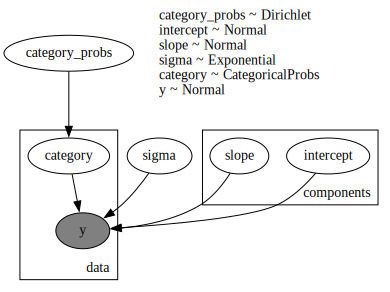

In [14]:
numpyro.render_model(mixture_model, model_args=(x,y), render_distributions=True)

In [17]:
# Set up the guide and the optimizer

init_values = {
    'category_probs': jnp.array([0.5, 0.5]),
    'intercept': jnp.array([0.0, 0.0]),
    'slope': jnp.array([0.0, 0.0]),
    'sigma': 0.05
}
guide = AutoDiagonalNormal(mixture_model, init_loc_fn=init_to_value(values=init_values))
optimizer = optim.Adam(step_size=1e-3)

# Set up SVI
svi = SVI(mixture_model, guide, optimizer, TraceEnum_ELBO())

In [18]:
svi_result = svi.run(random.PRNGKey(0), 20, x, y)

100
(100,)
100
(2, 1)


ValueError: Continuous inference cannot handle discrete sample site 'category'.

In [ ]:
# Run the optimizer
n_steps = 1000
for step in range(n_steps):
    svi_state, loss = svi.update(svi_state, x, y)

# Get the learned parameters
params = svi.get_params(svi_state)
print(params)

In [ ]:
params.keys()

NameError: name 'params' is not defined

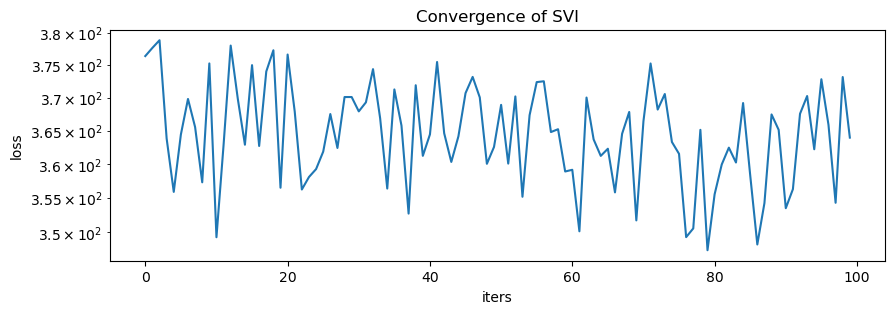

In [ ]:
plt.figure(figsize=(10, 3), dpi=100).set_facecolor("white")
plt.plot(svi_result.losses)
plt.xlabel("iters")
plt.ylabel("loss")
plt.yscale("log")
plt.title("Convergence of SVI")
plt.show()